In [1]:
__author__ = 'Stephanie Juneau <stephanie.juneau@noirlab.edu>'
__version__ = '20211121'
__datasets__ = ['unwise_dr1','allwise']  # datasets used in this notebook
__keywords__ = [''], # keywords relevant to this notebook, e.g. ['science case','dwarf galaxies'] Use only keywords from the master list: https://github.com/astro-datalab/notebooks-latest/blob/master/internal/keywords.txt

# Mid-Infrared Photometry from unWISE DR1 & AllWISE

*Stephanie Juneau (NSF's OIR Lab), Eddie Schlafly (LBNL), Aaron Meisner (NSF's OIR Lab) & the Astro Data Lab Team*

### Table of contents
* [Goals](#goals)
* [Disclaimer & Attribution](#attribution)
* [Introduction](#intro)
* [Imports & setup](#import)
* [Chapter 1: Queries to unWISE & AllWISE](#chapter1)
* [Chapter 2: Color & Magnitude Distributions](#chapter2)
* [Chapter 3: Color-Magnitude Diagrams of AllWISE & unWISE DR1](#chapter3)
* [Chapter 4: Plot location of query results in Galactic Coordinates](#chapter4)
* [Resources and references](#resources)

<a class="anchor" id="goals"></a>
# Goals
Compare the photometry (e.g., magnitude and color distributions) of the recent unWISE catalog (Schlafly et al 2019) to the original AllWISE catalog (Wright et al 2010) taking advantage of the unWISE DR1 and AllWISE databases at the Astro Data Lab. 

<a class="anchor" id="attribution"></a>
# Disclaimer & attribution
If you use this notebook for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445

* Data Lab Acknowledgements: https://datalab.noirlab.edu/docs/manual/UsingAstroDataLab/Introduction/AcknowledgementOfDataLab/AcknowledgementOfDataLab.html


Also familiarize yourself with the Data Lab disclaimers: https://datalab.noirlab.edu/disclaimers.php

<a class="anchor" id="intro"></a>
# Introduction

The unWISE catalog reaches deeper than the original All-WISE catalog thanks to including significantly deeper imaging, and to the use of improved modeling of crowded regions (Schlafly et al 2019). The new data correspond to an increase in exposure time by a factor of five (Figure 1).

<figure>
<img src="Figs/unWISE_Schlafly_fig2.jpeg", align="center", width=600>
<figcaption><b>Figure 1.</b> Figure from Schlafly et al (2019; their Figure 2) showing "AllWISE and unWISE compared with much deeper, higher resolution imaging from Spitzer–COSMOS, for a small portion of the COSMOS field. The three rows show 3.4 μm imaging of the same small patch of high-latitude sky from AllWISE (top), unWISE (middle), and Spitzer–COSMOS (right, 3.6 μm). The left column shows only the images, while the right column overplots the 5σ catalog entries from AllWISE (top) and unWISE (middle, bottom). The deeper unWISE stacks clearly allow many more sources to be detected, and the crowdsource catalog describes these well. Nevertheless, comparison with the Spitzer imaging reveals clear examples of unidentified sources (for instance, near (503, 1518)) and resolved sources that are split into multiple point sources (for instance, near (530, 1526)). Axis units are WISE pixels on coadd_id 1497p015."</figcaption>
</figure>



<a class="anchor" id="import"></a>
# Imports and setup

In [2]:
# std lib
from getpass import getpass

# 3rd party # remove imports that are not needed
import numpy as np
import pylab as plt
import matplotlib
%matplotlib inline
from astropy.utils.data import download_file  #import file from URL
from matplotlib.ticker import NullFormatter

# Data Lab
from dl import authClient as ac, queryClient as qc, storeClient as sc, helpers
from dl.helpers.utils import convert

# Learn about unWISE 'object' table
The command below will print the list of column names and descriptions.

In [3]:
#print(qc.schema('unwise_dr1.object'))

Below is an query from the *GettingStartedWithDataLab* notebook to quickly retrieve useful stats from the **tbl_stat** table.

In [4]:
#Retrieve useful stats, quickly
query="SELECT * FROM tbl_stat WHERE schema='unwise_dr1' and tbl_name='object'"

In [5]:
%time
info = qc.query(sql=query) # by default the result is a CSV formatted string

CPU times: user 6 µs, sys: 1e+03 ns, total: 7 µs
Wall time: 10.7 µs


In [6]:
print(info)  #NOTE: because unWISE is a foreign data table, it may not show up correctly in tbl_stat (in progress)

schema,tbl_name,nrows,ncols,nindex,table_size,indexes_size,total_size
unwise_dr1,object,2214718720,60,14,735 GB,540 GB,1275 GB



# Learn about AllWISE 'source' table
The command below will print the list of column names and descriptions, which is also available on the web interface: https://datalab.noirlab.edu/query.php?name=allwise.source

In [7]:
#print(qc.schema('allwise.source'))

In [8]:
#Retrieve useful stats, quickly
query="SELECT * FROM tbl_stat WHERE schema='allwise' and tbl_name='source'"

In [9]:
%time
info = qc.query(sql=query) # by default the result is a CSV formatted string

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 10.3 µs


In [10]:
print(info)

schema,tbl_name,nrows,ncols,nindex,table_size,indexes_size,total_size
allwise,source,747689280,100,9,360 GB,115 GB,475 GB



<a class="anchor" id="chapter1"></a>
# Chapter 1 - Queries to unWISE & AllWISE

## Query the unWISE 'object' table

In [11]:
query = """
        SELECT mag_w1_vg as w1, mag_w2_vg as w2, w1_w2_vg as w1_w2, 
               flux_w1/dflux_w1 as snr1, flux_w2/dflux_w2 as snr2, 
               ra, dec, glon, glat, spread_model_w1, dspread_model_w1 
        FROM unwise_dr1.object 
        WHERE (mag_w1_vg < 20 and mag_w2_vg < 20 and flux_w1/dflux_w1>5 and flux_w2/dflux_w2>5 and glat>50 and glat<60 and random_id>20 and random_id<21) 
        LIMIT 500000"""
print(query)

# Notes on the query:
# - S/N cuts in W1 & W2: flux_w1/dflux_w1>5 and flux_w2/dflux_w2>5
# - galactic latitude (glat) cuts in order to restrict to same part of sky for unWISE and allWISE
# - random_id cut to select randomly over the sky (besides the glat condition)
# 
# - To select on magnitudes instead:
#        WHERE (mag_w1_vg < 20 and mag_w2_vg < 20 and glat>50 and glat<60 and random_id>20 and random_id<21)
#


        SELECT mag_w1_vg as w1, mag_w2_vg as w2, w1_w2_vg as w1_w2, 
               flux_w1/dflux_w1 as snr1, flux_w2/dflux_w2 as snr2, 
               ra, dec, glon, glat, spread_model_w1, dspread_model_w1 
        FROM unwise_dr1.object 
        WHERE (mag_w1_vg < 20 and mag_w2_vg < 20 and flux_w1/dflux_w1>5 and flux_w2/dflux_w2>5 and glat>50 and glat<60 and random_id>20 and random_id<21) 
        LIMIT 500000


In [12]:
%%time
# This query may take a while (~1 min with limit 500000)
try:
    result = qc.query(sql=query,timeout=600) # by default the result is a CSV formatted string
except Exception as e:
    print(e.message)

CPU times: user 759 ms, sys: 371 ms, total: 1.13 s
Wall time: 32.4 s


In [13]:
# Convert the result to a Pandas Dataframe
df = convert(result,'pandas',na_values=('NaN','Infinity'))

In [14]:
# Print a few rows of the dataframe
print(df[:5])
len(df)

          w1         w2     w1_w2       snr1      snr2          ra        dec  \
0  17.511545  17.070599  0.440947  20.371399  8.016321  237.255484  47.381982   
1  18.165625  17.162722  1.002903  11.419026  7.335530  237.203214  47.453391   
2  17.535522  16.937910  0.597612  20.047981  8.999524  237.115025  47.433199   
3  17.333075  16.868095  0.464979  23.905336  9.632591  237.043170  47.420165   
4  17.154850  16.936937  0.217913  28.196568  9.324523  236.962291  47.573064   

        glon       glat  spread_model_w1  dspread_model_w1  
0  75.447776  50.008021         0.000917          0.001843  
1  75.569108  50.024508        -0.006829          0.003268  
2  75.561926  50.087308         0.003994          0.001885  
3  75.561312  50.137636        -0.004168          0.001590  
4  75.813734  50.151655         0.001754          0.001340  


294368

## Query the AllWISE 'source' table

In [15]:
query = """
        SELECT w1mpro as w1, w2mpro as w2, w1snr, w2snr,
               ra, dec, glon, glat, random_id, ph_qual
        FROM allwise.source
        WHERE (w1snr>5 and w2snr>5 and glat>50 and glat<60 and random_id > 20 and random_id < 21)
        LIMIT 500000"""
print(query)
#
# w1(2)snr = w1(2) signal-to-noise ratio
# ph_qual  = photometric quality flag
#


        SELECT w1mpro as w1, w2mpro as w2, w1snr, w2snr,
               ra, dec, glon, glat, random_id, ph_qual
        FROM allwise.source
        WHERE (w1snr>5 and w2snr>5 and glat>50 and glat<60 and random_id > 20 and random_id < 21)
        LIMIT 500000


In [16]:
%%time
# This query should take a while (~2 min with limit 500000)
try:
    result_all = qc.query(sql=query,timeout=600) # by default the result is a CSV formatted string
except Exception as e:
    print(e.message)

CPU times: user 297 ms, sys: 88.5 ms, total: 386 ms
Wall time: 3min 46s


In [17]:
# Convert the result to a Pandas Dataframe
df_all = convert(result_all,'pandas',na_values=('NaN','Infinity'))

In [18]:
# Print a few rows of the dataframe
print(df_all[:5])
len(df_all)

       w1      w2  w1snr  w2snr          ra        dec        glon       glat  \
0  16.564  16.081   11.3    5.7  150.260152  21.408570  211.807663  50.928848   
1  15.046  14.834   34.8   19.6  179.612385  64.512288  132.079457  51.664673   
2  15.729  15.760   28.5   10.5  227.186141  22.299595   31.756985  58.543845   
3  15.300  15.124   31.8   16.4  226.236736  15.253654   18.842683  56.822884   
4  12.038  12.053   48.5   48.3  146.708379  37.155630  186.495433  50.066822   

   random_id ph_qual  
0  20.000002    ABUU  
1  20.000362    AAUU  
2  20.000294    AAUU  
3  20.000300    AABU  
4  20.000301    AABU  


124764

### NOTE:
We can already see from the query results above that there are more objects in unWISE with S/N>5 in both W1 & W2 (N=294,368) relative to AllWISE (N=124,764).

<a class="anchor" id="chapter2"></a>
# Chapter 2 - Color & Magnitude Distributions

For reference, we will compate with the distributions of *W1-W2* color and *W1* magnitude from the cross-matched AllWISE-SDSS DR10 sample from the work of Kurcz et al (2016). Below, we will create distributions from our query results.

## Color Distributions for AllWISE & unWISE DR1

In [19]:
magthres = 16. #magnitude threshold to investigate bright (<16) vs. faint (>16)
colthres = 0.1 #color threshold in W1-W2 between blue and red for plotting below

# AllWISE (suffix "_all")
faint_w1_all  = df_all['w1']>magthres
bright_w1_all = df_all['w1']<=magthres
w1_w2_all = df_all['w1'] - df_all['w2']
blue_all  = w1_w2_all<=colthres
red_all   = w1_w2_all>colthres

# unWISE
faint_w1  = df['w1']>magthres
bright_w1 = df['w1']<=magthres
blue = df['w1_w2']<=colthres
red  = df['w1_w2']>colthres

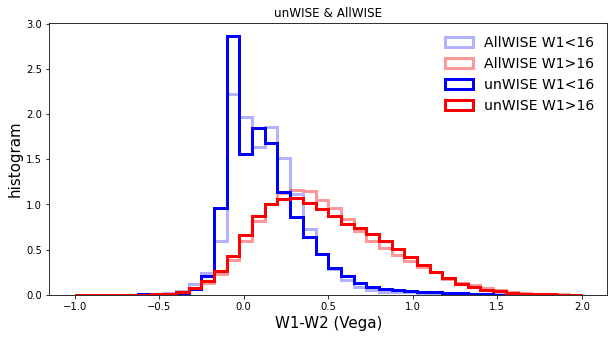

In [20]:
#W1-W2 Color distribution
fig, ax = plt.subplots(figsize=(10,5))
ax.hist(w1_w2_all[bright_w1_all],bins=40,density=True,range=(-1,2),histtype='step',lw=3,color='Blue',alpha=0.3,label='AllWISE W1<16')
ax.hist(w1_w2_all[faint_w1_all],bins=40,density=True,range=(-1,2),histtype='step',lw=3,color='Red',alpha=0.4,label='AllWISE W1>16')
ax.set_xlabel('W1-W2 (Vega)',fontsize=15)
ax.set_ylabel('histogram',fontsize=15)
ax.set_title('unWISE & AllWISE')
ax.hist(df['w1_w2'][bright_w1],bins=40,density=True,range=(-1,2),histtype='step',lw=3,color='Blue',alpha=1,label='unWISE W1<16')
ax.hist(df['w1_w2'][faint_w1],bins=40,density=True,range=(-1,2),histtype='step',lw=3,color='Red',alpha=1,label='unWISE W1>16')

ax.legend(loc='upper right',frameon=False,fontsize=14)

We can see from the Figure above that the color distributions are similar between AllWISE (light color histograms) and unWISE (darker color histograms) for both the *bright* (`W1<16`, in blue) and *faint* (`W1>16`, in red) objects in the tables.

## Color Distribution from AllWISE-SDSS DR10 Sample

<figure>
<img src="Figs/Kurcz2016_fig2.png", align="center", width=600>
<figcaption> For comparison, the figure above shows the distributions of W1-W2 color in Vega magnitudes from Kurcz et al (2016; their Figure 2). Above, the objects are separated according to their SDSS DR10 spectral classification into stars (green), galaxies (blue), and quasars (red). </figcaption>
</figure>

Comparing both figures suggests that the objects in the unWISE and AllWISE *bright* and *faint* distributions include a mixture of stars, galaxies and quasars, though the quasars are mostly found in the fainter objects (>16), for which the histograms reach redder `W1-W2` colors (>0.5).

## Magnitude Distributions for AllWISE & unWISE DR1

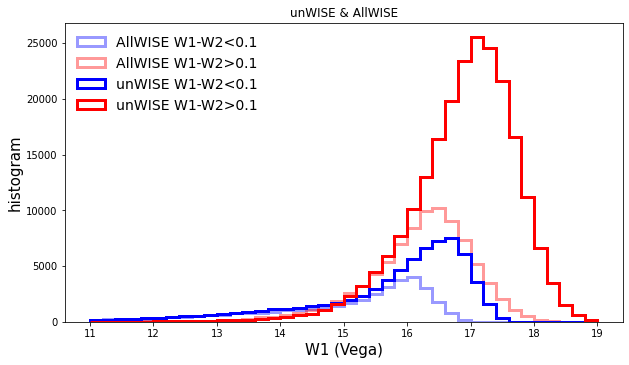

In [21]:
#W1 magnitude distributions (split into blue and red W1-W2) 
fig, ax = plt.subplots(figsize=(10,5.5))
ax.hist(df_all['w1'][blue_all],bins=40,density=False,range=(11,19),histtype='step',lw=3,color='Blue',alpha=0.4,label='AllWISE W1-W2<0.1')
ax.hist(df_all['w1'][red_all],bins=40,density=False,range=(11,19),histtype='step',lw=3,color='Red',alpha=0.4,label='AllWISE W1-W2>0.1')
ax.set_xlabel('W1 (Vega)',fontsize=15)
ax.set_ylabel('histogram',fontsize=15)
ax.set_title('unWISE & AllWISE')
ax.hist(df['w1'][blue],bins=40,density=False,range=(11,19),histtype='step',lw=3,color='Blue',alpha=1,label='unWISE W1-W2<0.1')
ax.hist(df['w1'][red],bins=40,density=False,range=(11,19),histtype='step',lw=3,color='Red',alpha=1,label='unWISE W1-W2>0.1')

ax.legend(loc='upper left',frameon=False,fontsize=14)

The figure above shows a comparison between the AllWISE (light colored histograms) and unWISE (dark colored histograms) magnitude distributions split between blue WISE colors (`W1-W2`<0.1, in blue) and red colors (`W1-W2`>0.1, in red). The histograms are *not* normalized so that we can also compare the absolute number of objects. This makes it obvious that the unWISE table contains many more fainter objects, and that both tables include a larger proportion of red objects relative to blue objects.

## Magnitude Distributions from AllWISE-SDSS DR10 Sample

<figure>
<img src="Figs/Kurcz2016_fig3.png", align="center", width=700>
<figcaption>Figure from Kurcz et al (2016; their Figure 3). The selection function above involves the SDSS optical selection for the main galaxy sample, which may be responsible to produce a sharp magnitude cutoff in W1 photometry for that class of objects.</figcaption>
</figure>

<a class="anchor" id="chapter3"></a>
# Chapter 3 - Color-Magnitude Diagrams of AllWISE & unWISE DR1

## Color-Magnitude Diagram: Scatter Plots 

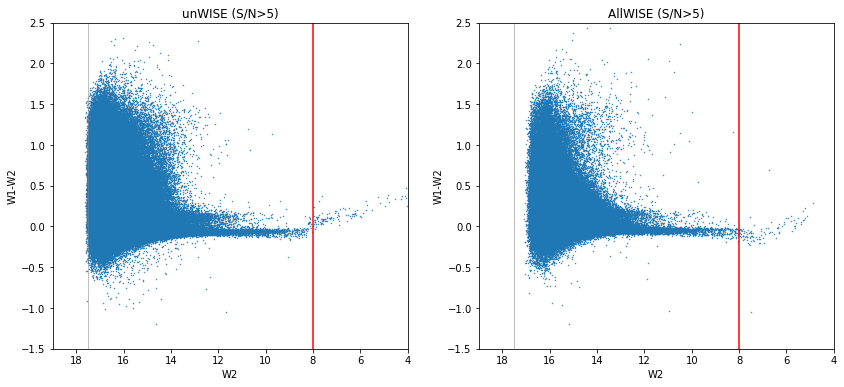

In [22]:
# define a 2-panel figure
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,6))

#first panel
x = df['w2']
y = df['w1_w2']
ax1.scatter(x,y,0.2)
ax1.set_xlabel('W2')
ax1.set_ylabel('W1-W2')
ax1.set_xlim((19,4))
ax1.set_ylim((-1.5,2.5))
ax1.set_title('unWISE (S/N>5)')

#Saturation at around 8 mag (would give unusual colors/mags)
ax1.axvline(x=8,color='Red')
ax1.axvline(x=17.5,color='Gray',lw=1,alpha=0.5)

#second panel
xx = df_all['w2']
yy = w1_w2_all
ax2.scatter(xx,yy,0.2)
ax2.set_xlabel('W2')
ax2.set_ylabel('W1-W2')
ax2.set_xlim((19,4))
ax2.set_ylim((-1.5,2.5))
ax2.set_title('AllWISE (S/N>5)')

#Saturation at around 8 mag (would give unusual colors/mags)
ax2.axvline(x=8,color='Red')
ax2.axvline(x=17.5,color='Gray',lw=1,alpha=0.5)

The figure above shows scatter plots of the color-magnitude distributions for unWISE (left-hand panel) and AllWISE (right-hand panel). The vertical gray line is fixed at `W2=17.5`, which is close to the detection limit of unWISE (with S/N>5). The red vertical line at `W2=8` marks the approximate magnitude where objects become saturated, which can yield unreliable magnitudes and colors brighter than this point. There are similarities between the two bivariate distributions such as the horizontal features around `W1-W2=-0.1` & `0.1`, and a significant broadening of the color distribution for objects fainter than `W2=14`.

## Color-Magnitude Diagram: 2D Histograms

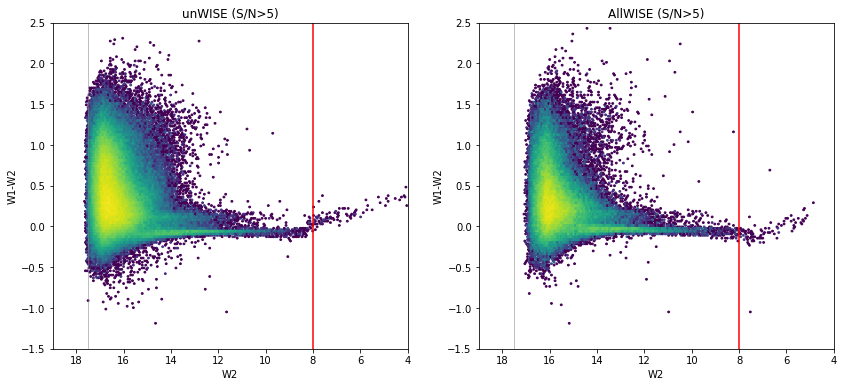

In [23]:
# set plotting ranges
xlims = (19,4)
ylims = (-1.5,2.5)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,6))

# first panel
x = df['w2']
y = df['w1_w2']
ax1.hexbin(x,y,bins='log',gridsize=200,extent=(xlims[0],xlims[1],ylims[0],ylims[1]),cmap=plt.cm.viridis, mincnt=1)
ax1.set_xlabel('W2')
ax1.set_ylabel('W1-W2')
ax1.set_xlim(xlims)
ax1.set_ylim(ylims)
ax1.set_title('unWISE (S/N>5)')

#Saturation at around 8 mag (would give unusual colors/mags)
ax1.axvline(x=8,color='Red')
ax1.axvline(x=17.5,color='Gray',lw=1,alpha=0.5)

# second panel
xx = df_all['w2']
yy = w1_w2_all
ax2.hexbin(xx,yy,bins='log',gridsize=200,extent=(xlims[0],xlims[1],ylims[0],ylims[1]),cmap=plt.cm.viridis, mincnt=1)
ax2.set_xlabel('W2')
ax2.set_ylabel('W1-W2')
ax2.set_xlim(xlims)
ax2.set_ylim(ylims)
ax2.set_title('AllWISE (S/N>5)')

#Saturation at around 8 mag (would give unusual colors/mags)
ax2.axvline(x=8,color='Red')
ax2.axvline(x=17.5,color='Gray',lw=1,alpha=0.5)

### NOTES:
The Color-Magnitude distributions of the unWISE and AllWISE datasets show that an obvious difference in sensitivity, with unWISE reaching about ~0.5 magnitudes deeper in `W2`. Their respective detection limits are around `W2>17.5` for unWISE (vertical grey line), and around `W2>17` for AllWISE. In addition, there are slight differences between the two bivariate distributions. For instance, the upper-right envelope displays a different shape. Users of this notebook can explore what the origin of the differences might be.

## Investigate cases with marginal S/N ratios in AllWISE

In [24]:
query = """
        SELECT w1mpro as w1, w2mpro as w2, w1snr, w2snr,
               ra, dec, glon, glat, random_id, ph_qual
        FROM allwise.source
        WHERE ((w1snr<5 or w2snr<5) and glat>50 and glat<60 and random_id > 20 and random_id < 21)
        LIMIT 500000"""

In [25]:
%%time
# This query should take a while (~2 min with limit 500000)
try:
    result_losnr = qc.query(sql=query,timeout=600) # by default the result is a CSV formatted string
except Exception as e:
    print(e.message)

CPU times: user 442 ms, sys: 127 ms, total: 569 ms
Wall time: 12.7 s


In [26]:
# Convert the result to a Pandas Dataframe
df_losnr = convert(result_losnr,'pandas')   #,na_values=('NaN','Infinity'))

In [27]:
# AllWISE
snr35_w1 = (df_losnr['w1snr']>3)&(df_losnr['w1snr']<5) # for testing below
snr35_w2 = (df_losnr['w2snr']>3)&(df_losnr['w2snr']<5)

w1_w2_losnr = df_losnr['w1']-df_losnr['w2']

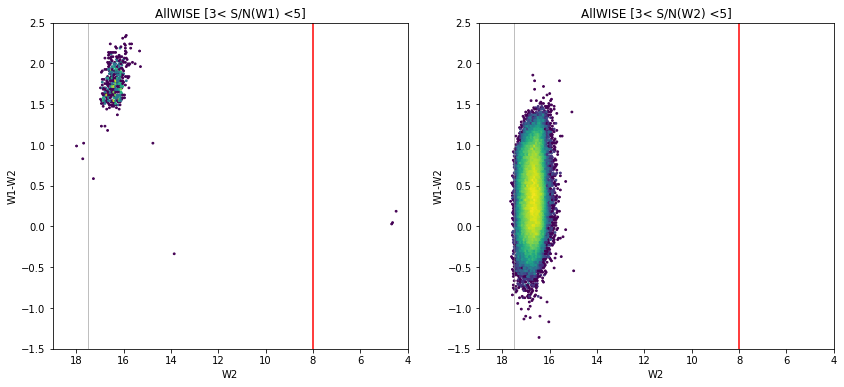

In [28]:
#define a 2-panel figure
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,6))

#first panel
x = df_losnr['w2'][snr35_w1]
y = w1_w2_losnr[snr35_w1]
ax1.hexbin(x,y,bins='log',gridsize=200,extent=(xlims[0],xlims[1],ylims[0],ylims[1]),cmap=plt.cm.viridis, mincnt=1)
ax1.set_xlabel('W2')
ax1.set_ylabel('W1-W2')
ax1.set_xlim(xlims)
ax1.set_ylim(ylims)
ax1.set_title('AllWISE [3< S/N(W1) <5]')

#Saturation at around 8 mag (would give unusual colors/mags)
ax1.axvline(x=8,color='Red')
ax1.axvline(x=17.5,color='Gray',lw=1,alpha=0.5)

#second panel
xx = df_losnr['w2'][snr35_w2]
yy = w1_w2_losnr[snr35_w2]
ax2.hexbin(xx,yy,bins='log',gridsize=200,extent=(xlims[0],xlims[1],ylims[0],ylims[1]),cmap=plt.cm.viridis, mincnt=1)
ax2.set_xlabel('W2')
ax2.set_ylabel('W1-W2')
ax2.set_xlim(xlims)
ax2.set_ylim(ylims)
ax2.set_title('AllWISE [3< S/N(W2) <5]')

#Saturation at around 8 mag (would give unusual colors/mags)
ax2.axvline(x=8,color='Red')
ax2.axvline(x=17.5,color='Gray',lw=1,alpha=0.5)

<a class="anchor" id="chapter4"></a>
# Chapter 4 -  Plot location of query results in Galactic Coordinates 

Below, we check the final sky location of the query results for unWISE and AllWISE, in Galactic coordinates. In the queries, we chose the following constraints: `glat>50 and glat<60` as well as `random_id > 20 and random_id < 21`. The former contraints are cuts in Galactic latitude, and the latter select 1 percent of the sample randomly distributed (between index 20-21, an arbitrary choice kept fixed for repeatability).

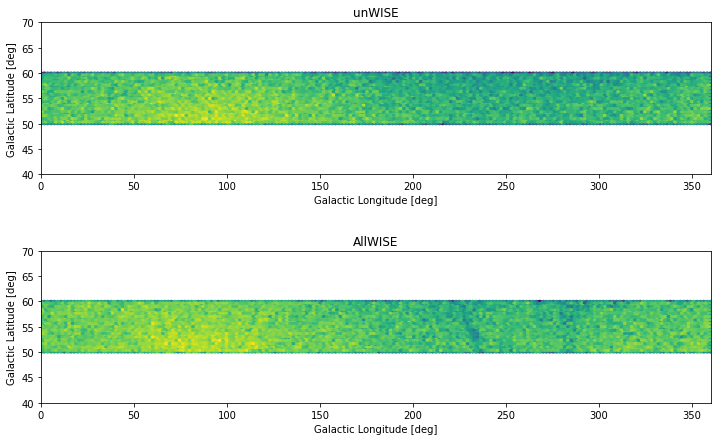

In [29]:
#define a 2-panel figure
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(12,7))

#first panel
x = df['glon']
y = df['glat']
ax1.hexbin(x,y,bins='log', cmap=plt.cm.viridis, mincnt=1,gridsize=(200,15))
ax1.set_xlabel('Galactic Longitude [deg]')
ax1.set_ylabel('Galactic Latitude [deg]')
ax1.set_xlim((0,360))
ax1.set_ylim((40,70))
title = ax1.set_title('unWISE')

#second panel
xx = df_all['glon']
yy = df_all['glat']
ax2.hexbin(xx,yy,bins='log', cmap=plt.cm.viridis, mincnt=1,gridsize=(200,15))
ax2.set_xlabel('Galactic Longitude [deg]')
ax2.set_ylabel('Galactic Latitude [deg]')
ax2.set_xlim((0,360))
ax2.set_ylim((40,70))
title = ax2.set_title('AllWISE')

fig.subplots_adjust(hspace=0.5)

### Repeat the galactic position plots but showing the distribution of objects with low S/N in AllWISE to check for any patterns.

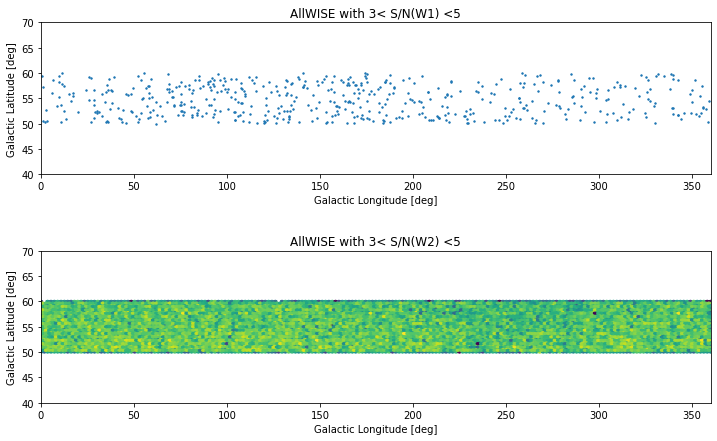

In [30]:
#define a 2-panel figure
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(12,7))

#first panel
x = df_losnr['glon'][snr35_w1]
y = df_losnr['glat'][snr35_w1]
ax1.scatter(x,y,s=2)
ax1.set_xlabel('Galactic Longitude [deg]')
ax1.set_ylabel('Galactic Latitude [deg]')
ax1.set_xlim((0,360))
ax1.set_ylim((40,70))
title = ax1.set_title('AllWISE with 3< S/N(W1) <5')

#second panel
xx = df_losnr['glon'][snr35_w2]
yy = df_losnr['glat'][snr35_w2]
ax2.hexbin(xx,yy,bins='log', cmap=plt.cm.viridis, mincnt=1,gridsize=(200,15))
ax2.set_xlabel('Galactic Longitude [deg]')
ax2.set_ylabel('Galactic Latitude [deg]')
ax2.set_xlim((0,360))
ax2.set_ylim((40,70))
title = ax2.set_title('AllWISE with 3< S/N(W2) <5')

fig.subplots_adjust(hspace=0.5)

From visual inspection, the sources with low S/N in the AllWISE *W1* (top panel) or *W2* (bottom panel) photometry are uniformly distributed on the area that we queried. This is unlike the sources with valid detections (S/N>5), which show enhanced number density around `70 < glon < 100` due to actual Galactic structure.

<a class="anchor" id="resources"></a>
# Resources and references

Schlafly et al (2019): *The unWISE Catalog: Two Billion Infrared Sources from Five Years of WISE Imaging*. Astrophysical Journal Supplement, 240, 30: https://ui.adsabs.harvard.edu/abs/2019ApJS..240...30S/abstract

Wright et al (2010): *The Wide-field Infrared Survey Explorer (WISE): Mission Description and Initial On-orbit Performance*, Astronomical Journal, 140, 1868: https://ui.adsabs.harvard.edu/abs/2010AJ....140.1868W/abstract 